In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
import pandas as pd
import kagglehub

# Download dataset
path = kagglehub.dataset_download("kartik2112/fraud-detection")

# Read CSV files dynamically
te_data = pd.read_csv(f"{path}/fraudTest.csv")
tr_data = pd.read_csv(f"{path}/fraudTrain.csv")

# Combine datasets
data = pd.concat([te_data, tr_data])

print("Dataset loaded successfully!")


100%|██████████| 202M/202M [00:01<00:00, 119MB/s]

Extracting files...


Dataset loaded successfully!


In [11]:
fraud_data = data[data['is_fraud'] == 1]
len(fraud_data)

9651

In [12]:
non_fraud_data = data[data['is_fraud'] == 0]
len(non_fraud_data)

1842743

In [13]:
test_fraud_data = fraud_data[:4000]
test_non_fraud_data = non_fraud_data[:4000]

val_fraud_data = fraud_data[4000:6000]
val_non_fraud_data = non_fraud_data[4000:6000]

train_fraud_data = fraud_data[6000:]
train_non_fraud_data = non_fraud_data[6000:]

test_data = pd.concat([test_fraud_data,test_non_fraud_data])
val_data = pd.concat([val_fraud_data,val_non_fraud_data])
train_data = pd.concat([train_fraud_data,train_non_fraud_data])

len(test_data), len(val_data), len(train_data)

(8000, 4000, 1840394)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import joblib

class AutoencoderModel(nn.Module):
    def __init__(self, input_size: int = 22, bottleneck_size: int = 7):
        super(AutoencoderModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, bottleneck_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()  # Using Sigmoid for output to keep it between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed

    def fit(self, X: torch.Tensor, num_epochs: int = 50, learning_rate: float = 0.001):
        # Set the model to training mode
        self.train()

        # Loss function and optimizer
        criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            optimizer.zero_grad()

            # Forward pass
            reconstructed = self(X)

            # Calculate loss
            loss = criterion(reconstructed, X)
            loss.backward()
            optimizer.step()

            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    def transform(self, X: torch.Tensor):
        # Set the model to evaluation mode
        self.eval()

        with torch.no_grad():
            encoded = self.encoder(X)  # Only return the encoded representation
        return encoded

    def save(self, filepath: str):
        joblib.dump(self, filepath)
        print(f"Model saved to {filepath}")

    @staticmethod
    def load(filepath: str):
        model = joblib.load(filepath)
        print(f"Model loaded from {filepath}")
        return model

In [15]:
import pandas as pd
import torch
import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler, DataLoader, TensorDataset, Subset
import random
import seaborn as sns
import joblib
from imblearn.over_sampling import SMOTE
import os

class DataProcessor():
    def __init__(self, scaler_path: str = "./scaler.pkl", autoencoder_path: str = "autoencoder_model.pkl"):
        self.scaler_path = scaler_path
        self.autoencoder_path = autoencoder_path

    def feature_selection(self, df: pd.DataFrame):
        drop_columns = ['cc_num','merchant','unix_time','merch_lat','merch_long','trans_year']
        df = df.drop(columns=drop_columns)
        return df

    def format_data(self, data: pd.DataFrame) -> tuple:
        # Convert the column names to lower case and replace spaces with underscores
        data.columns = data.columns.str.replace(' ', '_').str.lower()
        data = data.dropna()

        # Convert the date columns to datetime
        data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
        data['dob'] = pd.to_datetime(data['dob'])

        # Extract the year, month, day, hour and age from the date columns
        data['trans_year'] = data['trans_date_trans_time'].dt.year
        data['trans_month'] = data['trans_date_trans_time'].dt.month
        data['trans_day'] = data['trans_date_trans_time'].dt.day
        data['trans_hour'] = data['trans_date_trans_time'].dt.hour

        # Get the current year and calculate the age
        current_year = datetime.datetime.now().year
        data['age'] = current_year - data['dob'].dt.year

        # Drop unnecessary columns
        data = data.drop(columns=['trans_num', 'trans_date_trans_time', 'first', 'last', 'dob', 'unnamed:_0'])

        # Encode the string columns
        object_cols = data.select_dtypes(include=['object']).columns
        label_encoder = LabelEncoder()

        # Apply label encoding to string columns
        for col in object_cols:
            data[col] = label_encoder.fit_transform(data[col])

        return data

    def get_x_y(self, data: pd.DataFrame) -> tuple:
        X = torch.tensor(data.values,dtype=torch.float)

        try:
            y = torch.tensor(data['is_fraud'].values,dtype=torch.long)
        except:
            y = None

        return X, y

    def check_for_imbalance(self, data: pd.DataFrame) -> tuple:
        data.columns = data.columns.str.replace(' ', '_').str.lower()
        num_class_0 = data[data['is_fraud'] == 0].shape[0]
        num_class_1 = data[data['is_fraud'] == 1].shape[0]

        data = [num_class_1, num_class_0]
        keys = ['Is Fraud', 'Not Fraud']

        # define Seaborn color palette to use
        palette_color = sns.color_palette('bright')

        # plotting data on chart
        plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')

        # displaying chart
        plt.show()

        print(f"Non-Fraud data count: {num_class_0}")
        print(f"Fraud data count: {num_class_1}")
        return num_class_0, num_class_1

    def apply_sampler(self, X: torch.Tensor, y: torch.Tensor, num_class_0: int, num_class_1: int) -> tuple:
        # Create weights for each sample
        sample_weights = [1.0 / num_class_0 if label == 0 else 1.0 / num_class_1 for label in y]

        # Create the sampler
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        dataset = TensorDataset(X, y)

        # Create DataLoader with the sampler
        dataloader = DataLoader(dataset, sampler=sampler, batch_size=len(y))  # Use the entire dataset

        # Count classes
        class_counts = {0: 0, 1: 0}
        valid_inputs_list = []  # To store inputs
        valid_labels_list = []  # To store labels

        for inputs, labels in dataloader:
            valid_inputs_list.append(inputs)
            valid_labels_list.append(labels)

            # Count occurrences of each class
            class_counts[0] += (labels == 0).sum().item()
            class_counts[1] += (labels == 1).sum().item()

        print(f'Class distribution: {class_counts}')

        # Create newX and newY from the concatenated lists
        newX = torch.cat(valid_inputs_list)  # Concatenate tensors
        newY = torch.cat(valid_labels_list)  # Concatenate tensors

        return newX, newY

    def apply_smote(self, X: torch.Tensor, y: torch.Tensor) -> tuple:
        # Convert torch Tensors to NumPy arrays, as SMOTE works with NumPy
        X_np = X.cpu().numpy()
        y_np = y.cpu().numpy()

        # Apply SMOTE to generate synthetic samples for the minority class
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_np, y_np)

        # Convert back to torch Tensors
        newX = torch.tensor(X_resampled, dtype=torch.float32).to(X.device)
        newY = torch.tensor(y_resampled, dtype=torch.float32).to(y.device)

        # Count classes after SMOTE
        class_counts = {0: (newY == 0).sum().item(), 1: (newY == 1).sum().item()}
        print(f'Class distribution after SMOTE: {class_counts}')

        return newX, newY

    def split(self, X: torch.Tensor, y: torch.Tensor, val_size: int, test_size: int) -> tuple:
        # Check if the percentages are valid
        if val_size + test_size >= 100:
            raise ValueError("Sum of validation and test sizes must be less than 100.")

        train_size = 100 - val_size - test_size

        # Combine X and y into a single dataset
        full_dataset = TensorDataset(X, y)
        num_samples = len(full_dataset)

        # Shuffle the indices for randomness
        indices = list(range(num_samples))
        random.shuffle(indices)

        # Calculate split indices
        train_size = int(num_samples * (train_size / 100))
        val_size = int(num_samples * (val_size / 100))
        test_size = num_samples - train_size - val_size  # Ensure the remaining samples go to test

        # Create subsets
        train_indices = indices[:train_size]
        val_indices = indices[train_size:train_size + val_size]
        test_indices = indices[train_size + val_size:]

        # Create subsets
        train_subset = Subset(full_dataset, train_indices)
        val_subset = Subset(full_dataset, val_indices)
        test_subset = Subset(full_dataset, test_indices)

        # Split the subsets into X and y
        X_train, y_train = zip(*[train_subset[i] for i in range(len(train_subset))])
        X_val, y_val = zip(*[val_subset[i] for i in range(len(val_subset))])
        X_test, y_test = zip(*[test_subset[i] for i in range(len(test_subset))])

        # Convert back to tensors
        X_train, y_train = torch.stack(X_train), torch.stack(y_train)
        X_val, y_val = torch.stack(X_val), torch.stack(y_val)
        X_test, y_test = torch.stack(X_test), torch.stack(y_test)

        return X_train, y_train, X_val, y_val, X_test, y_test

    def apply_feature_scaling(self, X_train: torch.Tensor, X_val: torch.Tensor, X_test: torch.Tensor) -> tuple:
        # check if the scaler exists
        if os.path.exists(self.scaler_path):
            scaler = joblib.load(self.scaler_path)
        else:
            scaler = MinMaxScaler()

            # Fit the scaler on the training data
            scaler.fit(X_train.numpy())  # Fit the scaler using NumPy format of training data

            # Save the scaler
            joblib.dump(scaler, self.scaler_path)

        # Scale the training data
        scaled_X_train = torch.tensor(scaler.transform(X_train.numpy()), dtype=torch.float)

        # Scale the validation data
        scaled_X_val = torch.tensor(scaler.transform(X_val.numpy()), dtype=torch.float)

        # Scale the test data
        scaled_X_test = torch.tensor(scaler.transform(X_test.numpy()), dtype=torch.float)

        # Debugging: check shapes of the scaled data
        print(f"Scaled X_train shape: {scaled_X_train.shape}")
        print(f"Scaled X_val shape: {scaled_X_val.shape}")
        print(f"Scaled X_test shape: {scaled_X_test.shape}")

        return scaled_X_train, scaled_X_val, scaled_X_test

    def apply_encode(self, X_train: torch.Tensor, X_val: torch.Tensor, X_test: torch.Tensor, features: int, epoch: int = 100, rl: float = 0.001) -> tuple:
        # check if the autoencoder exists
        if os.path.exists(self.autoencoder_path):
            autoencoder = joblib.load(self.autoencoder_path)
        else:
            autoencoder = AutoencoderModel(input_size=X_train.shape[1], bottleneck_size=features)
            autoencoder.fit(X_train, num_epochs=epoch, learning_rate=rl)
            # Save the model
            joblib.dump(autoencoder, self.autoencoder_path)

        # Transform the data
        encoded_X_train = autoencoder.transform(X_train)
        encoded_X_val = autoencoder.transform(X_val)
        encoded_X_test = autoencoder.transform(X_test)

        return encoded_X_train, encoded_X_val, encoded_X_test

    def create_data_loaders(
        self,
        X_train: torch.Tensor,
        y_train: torch.Tensor,
        X_val: torch.Tensor,
        y_val: torch.Tensor,
        X_test: torch.Tensor,
        y_test: torch.Tensor,
        batch_size: int
    ) -> tuple:
        # Create TensorDataset for each set
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        test_dataset = TensorDataset(X_test, y_test)

        # Create DataLoaders for each set
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

    def plot_class_distribution(self, X: torch.Tensor, y: torch.Tensor):
        # Convert y tensor to NumPy array for counting
        y_np = y.cpu().numpy()  # Move to CPU and convert to NumPy

        # convert y_np to int
        y_np = y_np.astype(int)

        # Count occurrences of each class
        class_counts = np.bincount(y_np)

        data = [class_counts[1], class_counts[0]]
        keys = ['Is Fraud', 'Not Fraud']

        # define Seaborn color palette to use
        palette_color = sns.color_palette('bright')

        # plotting data on chart
        plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')

        # displaying chart
        plt.show()

    def preprocess(self, X: torch.Tensor) -> torch.Tensor:
        # Apply feature scaling
        scaler = joblib.load(self.scaler_path)
        scaled_X = torch.tensor(scaler.transform(X.numpy()), dtype=torch.float)

        # Apply Encode
        autoencoder = joblib.load(self.autoencoder_path)
        encoded_X = autoencoder.transform(scaled_X)

        return encoded_X

In [16]:
data_processor = DataProcessor(
    scaler_path="/content/scaler.pkl",
    autoencoder_path="/content/autoencoder.pkl"
)

In [17]:
test_data = data_processor.format_data(test_data)
val_data = data_processor.format_data(val_data)
len(test_data), len(val_data)

(8000, 4000)

In [18]:
train_data = data_processor.format_data(train_data)
train_data

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,...,job,unix_time,merch_lat,merch_long,is_fraud,trans_year,trans_month,trans_day,trans_hour,age
654344,4260128500325,87,4,272.23,0,35,197,16,41812,37.2409,...,100,1349482305,37.886262,-83.193317,1,2019,10,6,0,28
654382,4260128500325,327,8,839.80,0,35,197,16,41812,37.2409,...,100,1349483718,37.607048,-82.527339,1,2019,10,6,0,28
654420,4260128500325,466,4,299.49,0,35,197,16,41812,37.2409,...,100,1349485156,37.424833,-81.856802,1,2019,10,6,0,28
654438,4260128500325,389,2,11.19,0,35,197,16,41812,37.2409,...,100,1349486025,37.190954,-83.411481,1,2019,10,6,1,28
654487,639030014711,607,2,7.44,1,666,583,13,62970,37.1935,...,280,1349487555,36.514962,-89.527343,1,2019,10,6,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,30263540414123,499,0,15.56,1,149,318,43,84735,37.7175,...,209,1371816728,36.841266,-111.690765,0,2020,6,21,12,64
1296671,6011149206456997,2,1,51.70,1,825,787,19,21790,39.2667,...,352,1371816739,38.906881,-78.246528,0,2020,6,21,12,46
1296672,3514865930894695,599,1,105.93,1,152,334,31,88325,32.9396,...,301,1371816752,33.619513,-105.130529,0,2020,6,21,12,58
1296673,2720012583106919,509,1,74.90,1,418,455,40,57756,43.3526,...,475,1371816816,42.788940,-103.241160,0,2020,6,21,12,45


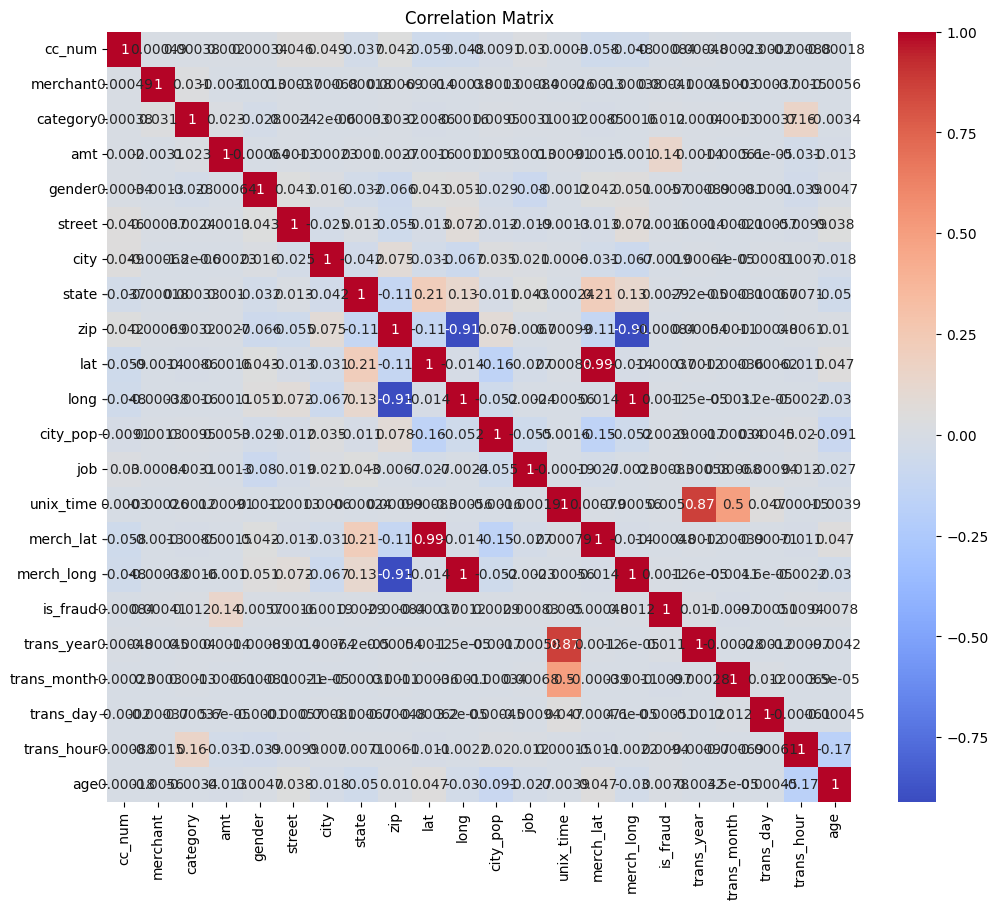

In [19]:


plt.figure(figsize=(12, 10))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [20]:
test_data = data_processor.feature_selection(test_data)
val_data = data_processor.feature_selection(val_data)
train_data = data_processor.feature_selection(train_data)
train_data

,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,is_fraud,trans_month,trans_day,trans_hour,age
654344,4,272.23,0,35,197,16,41812,37.2409,-82.7696,230,100,1,10,6,0,28
654382,8,839.80,0,35,197,16,41812,37.2409,-82.7696,230,100,1,10,6,0,28
654420,4,299.49,0,35,197,16,41812,37.2409,-82.7696,230,100,1,10,6,0,28
654438,2,11.19,0,35,197,16,41812,37.2409,-82.7696,230,100,1,10,6,1,28
654487,2,7.44,1,666,583,13,62970,37.1935,-89.0933,639,280,1,10,6,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,0,15.56,1,149,318,43,84735,37.7175,-112.4777,258,209,0,6,21,12,64
1296671,1,51.70,1,825,787,19,21790,39.2667,-77.5101,100,352,0,6,21,12,46
1296672,1,105.93,1,152,334,31,88325,32.9396,-105.8189,899,301,0,6,21,12,58
1296673,1,74.90,1,418,455,40,57756,43.3526,-102.5411,1126,475,0,6,21,12,45


In [21]:
# Format Dataframe to Tensor
X_train, y_train = data_processor.get_x_y(train_data)
X_test, y_test = data_processor.get_x_y(test_data)
X_val, y_val = data_processor.get_x_y(val_data)
X_train[:5], y_train[:5]

(tensor([[ 4.0000e+00,  2.7223e+02,  0.0000e+00,  3.5000e+01,  1.9700e+02,
           1.6000e+01,  4.1812e+04,  3.7241e+01, -8.2770e+01,  2.3000e+02,
           1.0000e+02,  1.0000e+00,  1.0000e+01,  6.0000e+00,  0.0000e+00,
           2.8000e+01],
         [ 8.0000e+00,  8.3980e+02,  0.0000e+00,  3.5000e+01,  1.9700e+02,
           1.6000e+01,  4.1812e+04,  3.7241e+01, -8.2770e+01,  2.3000e+02,
           1.0000e+02,  1.0000e+00,  1.0000e+01,  6.0000e+00,  0.0000e+00,
           2.8000e+01],
         [ 4.0000e+00,  2.9949e+02,  0.0000e+00,  3.5000e+01,  1.9700e+02,
           1.6000e+01,  4.1812e+04,  3.7241e+01, -8.2770e+01,  2.3000e+02,
           1.0000e+02,  1.0000e+00,  1.0000e+01,  6.0000e+00,  0.0000e+00,
           2.8000e+01],
         [ 2.0000e+00,  1.1190e+01,  0.0000e+00,  3.5000e+01,  1.9700e+02,
           1.6000e+01,  4.1812e+04,  3.7241e+01, -8.2770e+01,  2.3000e+02,
           1.0000e+02,  1.0000e+00,  1.0000e+01,  6.0000e+00,  1.0000e+00,
           2.8000e+01],
    

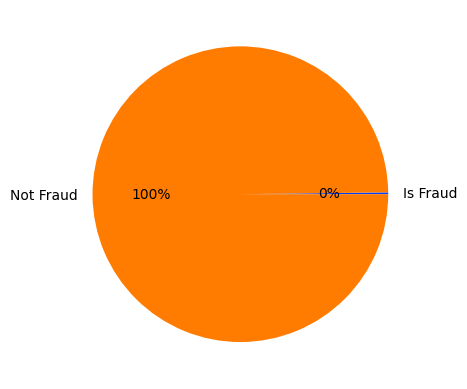

Non-Fraud data count: 1836743
Fraud data count: 3651


In [22]:
num_class_0, num_class_1 = data_processor.check_for_imbalance(train_data)

In [23]:
# Apply Data Sampling
X_train, y_train = data_processor.apply_smote(X_train, y_train)
len(X_train), len(y_train)

Class distribution after SMOTE: {0: 1836743, 1: 1836743}


(3673486, 3673486)

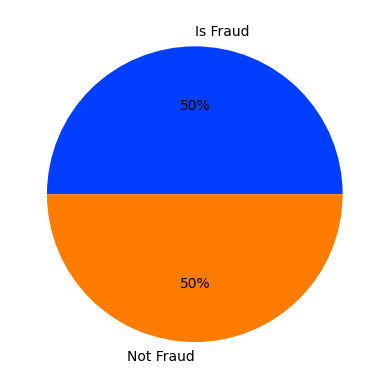

In [24]:
data_processor.plot_class_distribution(X_train, y_train)

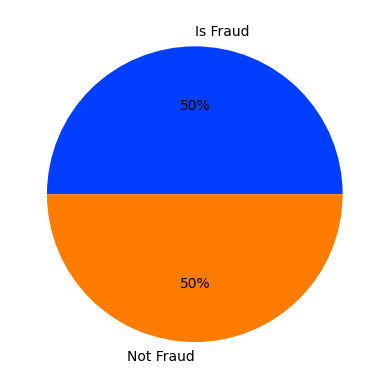

In [25]:
data_processor.plot_class_distribution(X_val, y_val)

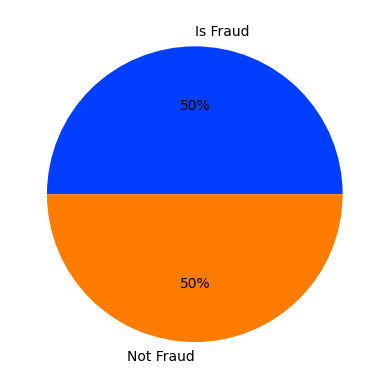

In [26]:
data_processor.plot_class_distribution(X_test, y_test)

In [27]:
# Feature Scaling
X_train, X_val, X_test = data_processor.apply_feature_scaling(X_train, X_val, X_test)
X_train[:5], X_val[:5], X_test[:5]

Scaled X_train shape: torch.Size([3673486, 16])
Scaled X_val shape: torch.Size([4000, 16])
Scaled X_test shape: torch.Size([8000, 16])


(tensor([[3.0769e-01, 9.3696e-03, 0.0000e+00, 3.7076e-02, 2.2827e-01, 3.2653e-01,
          4.1162e-01, 3.7698e-01, 8.4835e-01, 7.1215e-05, 2.0704e-01, 1.0000e+00,
          8.1818e-01, 1.6667e-01, 0.0000e+00, 9.8765e-02],
         [6.1538e-01, 2.8976e-02, 0.0000e+00, 3.7076e-02, 2.2827e-01, 3.2653e-01,
          4.1162e-01, 3.7698e-01, 8.4835e-01, 7.1215e-05, 2.0704e-01, 1.0000e+00,
          8.1818e-01, 1.6667e-01, 0.0000e+00, 9.8765e-02],
         [3.0769e-01, 1.0311e-02, 0.0000e+00, 3.7076e-02, 2.2827e-01, 3.2653e-01,
          4.1162e-01, 3.7698e-01, 8.4835e-01, 7.1215e-05, 2.0704e-01, 1.0000e+00,
          8.1818e-01, 1.6667e-01, 0.0000e+00, 9.8765e-02],
         [1.5385e-01, 3.5201e-04, 0.0000e+00, 3.7076e-02, 2.2827e-01, 3.2653e-01,
          4.1162e-01, 3.7698e-01, 8.4835e-01, 7.1215e-05, 2.0704e-01, 1.0000e+00,
          8.1818e-01, 1.6667e-01, 4.3478e-02, 9.8765e-02],
         [1.5385e-01, 2.2247e-04, 1.0000e+00, 7.0551e-01, 6.7555e-01, 2.6531e-01,
          6.2636e-01, 3.75

In [28]:
# Apply Encoder
X_train, X_val, X_test = data_processor.apply_encode(X_train, X_val, X_test, 7)
X_train[:5], X_val[:5], X_test[:5]

Epoch [1/100], Loss: 0.1274
Epoch [2/100], Loss: 0.1266
Epoch [3/100], Loss: 0.1258
Epoch [4/100], Loss: 0.1250
Epoch [5/100], Loss: 0.1243
Epoch [6/100], Loss: 0.1236
Epoch [7/100], Loss: 0.1229
Epoch [8/100], Loss: 0.1223
Epoch [9/100], Loss: 0.1216
Epoch [10/100], Loss: 0.1210
Epoch [11/100], Loss: 0.1203
Epoch [12/100], Loss: 0.1197
Epoch [13/100], Loss: 0.1191
Epoch [14/100], Loss: 0.1185
Epoch [15/100], Loss: 0.1178
Epoch [16/100], Loss: 0.1172
Epoch [17/100], Loss: 0.1166
Epoch [18/100], Loss: 0.1159
Epoch [19/100], Loss: 0.1153
Epoch [20/100], Loss: 0.1146
Epoch [21/100], Loss: 0.1140
Epoch [22/100], Loss: 0.1133
Epoch [23/100], Loss: 0.1126
Epoch [24/100], Loss: 0.1118
Epoch [25/100], Loss: 0.1110
Epoch [26/100], Loss: 0.1102
Epoch [27/100], Loss: 0.1094
Epoch [28/100], Loss: 0.1085
Epoch [29/100], Loss: 0.1076
Epoch [30/100], Loss: 0.1067
Epoch [31/100], Loss: 0.1057
Epoch [32/100], Loss: 0.1047
Epoch [33/100], Loss: 0.1036
Epoch [34/100], Loss: 0.1025
Epoch [35/100], Loss: 0

(tensor([[-0.6806,  0.0576,  0.8199, -1.4606,  1.3358,  1.4048,  0.7590],
         [-0.6960,  0.0392,  0.8600, -1.6189,  1.4657,  1.5314,  0.8615],
         [-0.6805,  0.0575,  0.8200, -1.4608,  1.3360,  1.4050,  0.7591],
         [-0.6900,  0.0541,  0.8158, -1.3983,  1.2883,  1.3542,  0.7230],
         [-1.8783,  0.9853,  1.5444, -1.2806,  1.4217,  1.3787, -0.1748]]),
 tensor([[-0.9134,  0.1682,  1.0103, -2.0176,  1.3966,  1.4493,  1.0200],
         [-1.3279,  1.0787,  0.7910, -1.5065,  1.1830,  1.4659, -0.3005],
         [-1.7149,  0.8350,  1.3930, -1.2326,  1.1448,  1.2277, -0.2187],
         [-0.9501,  0.3673,  0.9897, -2.1215,  1.5068,  1.5322,  1.0203],
         [-0.9434,  0.1381,  1.0574, -2.1586,  1.5054,  1.5672,  1.1131]]),
 tensor([[-1.3272, -0.0926,  1.5765, -2.0416,  1.8184,  1.7196,  1.2684],
         [-1.8653,  1.0331,  1.5007, -2.1077,  1.8931,  2.1608, -0.0644],
         [-1.8298,  1.0904,  1.4111, -1.8144,  1.6477,  1.9275, -0.2678],
         [-1.9974,  0.6736,  1.625

In [29]:
train_loader, val_loader, test_loader = data_processor.create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=16)
len(train_loader), len(val_loader), len(test_loader)

(229593, 250, 500)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, auc, precision_recall_curve
import pandas as pd

class Model(nn.Module):
    def __init__(self, input_size, model_path: str = None):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.0001)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=3, verbose=True)

        if model_path:
            self.load_checkpoint(model_path)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

    def set_loss_fn(self, loss_fn):
        self.loss_fn = loss_fn

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_scheduler(self, scheduler):
        self.scheduler = scheduler

    def save_checkpoint(self, filepath: str):
        torch.save({
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
        }, filepath)
        print(f"Checkpoint saved to {filepath}")

    def load_checkpoint(self, filepath: str):
        checkpoint = torch.load(filepath, map_location=device)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print(f"Checkpoint loaded from {filepath}")

    def train_model(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int = 10,
        patience: int = 5,
        checkpoint_path: str = 'model_checkpoint.pth',
        show_plot: bool = True
    ):
        # Transfer the model to GPU if available
        self.to(device)

        train_losses = []
        val_losses = []

        best_val_loss = float('inf')
        epochs_no_improve = 0  # Early stopping counter

        for epoch in range(num_epochs):
            self.train()  # Set the model to training mode
            epoch_loss = 0
            correct_predictions = 0  # Initialize correct predictions counter
            total_predictions = 0  # Initialize total predictions counter

            print(f"Epoch {epoch + 1}/{num_epochs}")

            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                logits = self(inputs)

                # Calculate loss
                loss = self.loss_fn(logits.squeeze(), targets.float())

                # Backward pass and optimizer step
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Calculate accuracy
                y_pred_prob = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
                y_pred_binary = (y_pred_prob >= 0.5).float()  # Threshold to get binary predictions
                correct_predictions += (y_pred_binary.view(-1) == targets).sum().item()  # Count correct predictions
                total_predictions += targets.size(0)  # Count total predictions

                epoch_loss += loss.item()

                if (batch_idx + 1) % 10000 == 0:
                    print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

            avg_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_loss)

            # Calculate and print training accuracy after the epoch
            train_accuracy = correct_predictions / total_predictions
            print(f"Avg Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

            # Validation phase
            self.eval()  # Set the model to evaluation mode
            val_loss = 0
            val_correct_predictions = 0  # Initialize correct predictions for validation
            val_total_predictions = 0  # Initialize total predictions for validation

            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_logits = self(val_inputs)
                    val_loss += self.loss_fn(val_logits.squeeze(), val_targets.float()).item()

                    # Calculate validation accuracy
                    val_y_pred_prob = torch.sigmoid(val_logits)  # Apply sigmoid to get probabilities
                    val_y_pred_binary = (val_y_pred_prob >= 0.5).float()  # Threshold to get binary predictions
                    val_correct_predictions += (val_y_pred_binary.view(-1) == val_targets).sum().item()  # Count correct predictions
                    val_total_predictions += val_targets.size(0)  # Count total predictions

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Calculate and print validation accuracy after the epoch
            val_accuracy = val_correct_predictions / val_total_predictions
            print(f"Avg Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Step the scheduler
            self.scheduler.step(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0  # Reset counter
                # Save checkpoint when validation loss improves
                self.save_checkpoint(checkpoint_path)
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print("Early stopping triggered!")
                break  # Stop training if no improvement

        if show_plot:
            # Plotting the training loss curve
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title('Loss Curve')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

    def test_model(self, test_loader: DataLoader,show_plot=True):
        self.to(device)

        self.eval()  # Set the model to evaluation mode
        test_loss = 0
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        y_pred_prob = []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                logits = self(inputs)
                loss = self.loss_fn(logits.squeeze(), targets.float())
                test_loss += loss.item()

                # Collect predictions
                predicted = torch.sigmoid(logits) >= 0.5  # Apply sigmoid and threshold
                y_true.extend(targets.cpu().numpy())
                y_pred.extend(predicted.view(-1).cpu().numpy())
                y_pred_prob.extend(torch.sigmoid(logits).view(-1).cpu().numpy())

                correct += (predicted.view(-1).float() == targets).sum().item()
                total += targets.size(0)

        avg_test_loss = test_loss / len(test_loader)
        accuracy = correct / total

        print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

        # Evaluate metrics
        self.evaluate_metrics(y_true, y_pred, y_pred_prob, show_plot=show_plot)

    def evaluate_metrics(self, y_true, y_pred, y_pred_prob, show_plot=True):
        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print(f'Confusion Matrix:\n TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')

        # Precision, Recall, F1-Score
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-Score: {f1:.4f}')

        # AUC-ROC
        auc_roc = roc_auc_score(y_true, y_pred_prob)
        print(f'AUC-ROC: {auc_roc:.4f}')

        # AUC-PR
        precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
        auc_pr = auc(recall_vals, precision_vals)
        print(f'AUC-PR: {auc_pr:.4f}')

        # plot confusion matrix
        if show_plot:
            from sklearn.metrics import ConfusionMatrixDisplay
            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.show()

    def predict_tensor(self, X, threshold=0.5):
        logits = self(X)
        probabilities = torch.sigmoid(logits)
        predictions = (probabilities >= threshold).int()
        return predictions

    def predict_csv(self, file_path: str):
        # Load the data
        raw_data = pd.read_csv(file_path)

        # Preprocess the data
        processor = DataProcessor()
        X = processor.format_data(raw_data)
        X = processor.preprocess(X)

        with torch.no_grad():
            predictions = self.predict_tensor(X)

        return predictions

    def predict_df(self, df: pd.DataFrame):
        # Preprocess the data
        processor = DataProcessor()
        X = processor.format_data(df)
        X = processor.preprocess(X)

        with torch.no_grad():
            predictions = self.predict_tensor(X)

        return predictions

In [31]:
model = Model(input_size=7)
model

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
)

Epoch 1/3
Batch 10000/229593, Loss: 0.0012
Batch 20000/229593, Loss: 0.0000
Batch 30000/229593, Loss: 0.0000
Batch 40000/229593, Loss: 0.0002
Batch 50000/229593, Loss: 0.0001
Batch 60000/229593, Loss: 0.0002
Batch 70000/229593, Loss: 0.0001
Batch 80000/229593, Loss: 0.0000
Batch 90000/229593, Loss: 0.0000
Batch 100000/229593, Loss: 0.0012
Batch 110000/229593, Loss: 0.0000
Batch 120000/229593, Loss: 0.0001
Batch 130000/229593, Loss: 0.0001
Batch 140000/229593, Loss: 0.0001
Batch 150000/229593, Loss: 0.0001
Batch 160000/229593, Loss: 0.0001
Batch 170000/229593, Loss: 0.0000
Batch 180000/229593, Loss: 0.0717
Batch 190000/229593, Loss: 0.0001
Batch 200000/229593, Loss: 0.0000
Batch 210000/229593, Loss: 0.0001
Batch 220000/229593, Loss: 0.0000
Avg Loss: 0.0015, Train Accuracy: 0.9995
Avg Val Loss: 0.0007, Val Accuracy: 1.0000
Checkpoint saved to /content/model_checkpoint.pth
Epoch 2/3
Batch 10000/229593, Loss: 0.0000
Batch 20000/229593, Loss: 0.0001
Batch 30000/229593, Loss: 0.0001
Batch 40

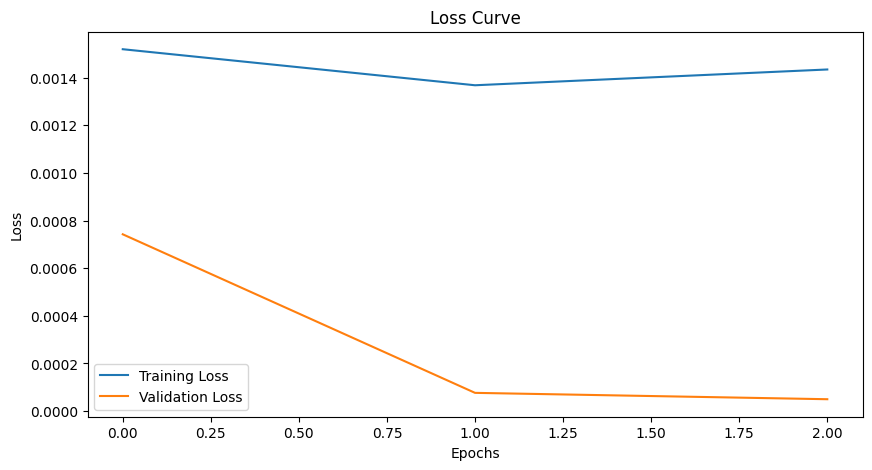

In [33]:
model.train_model(train_loader, val_loader, num_epochs=3, checkpoint_path="/content/model_checkpoint.pth")

Test Loss: 0.0001, Test Accuracy: 1.0000
Confusion Matrix:
 TP: 4000, FP: 0, TN: 4000, FN: 0
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000
AUC-PR: 1.0000


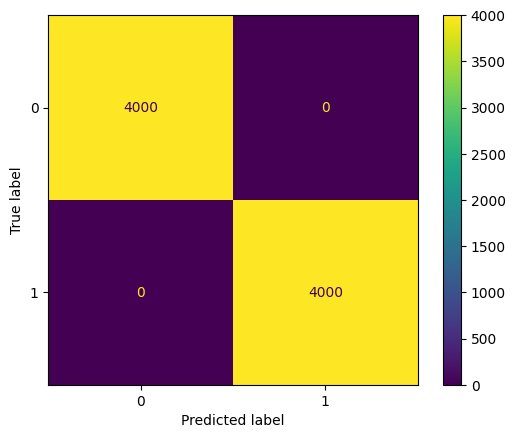

In [34]:
model.test_model(test_loader)